# 0.개념

- 연관성 분석은 각 항목들을 독립적인 것으로 판단하여 규칙을 생성하지만, 장바구니 분석은 항목 간의 hierarchical 관계까지 고려
- 하나의 거래나 사건에 포한되어 있는 항목들의 관련성을 파악
- 둘 이상의 항목들로 구성된 연관성 규칙을 찾아내는 탐색적 모델링

**여러 행위자와 여러 항목으로 구성된 데이터셋에서 가장 빈번하게 발생한 항목 규칙을 찾아낼 때 사용**

# 1.분석

## 1)데이터 로드

장바구니 분석에 필요한 데이터

- 고객 아이디(CLNT_ID) : 고객 구분
- 날짜(SESS_DT) : 구매 날짜 구분
- 상품 코드(PD_C) : 구매 상푼 구분

In [1]:
import pandas as pd
import warnings

# 경고 무시
warnings.filterwarnings('ignore')

product = pd.read_csv("data/Product.csv")
# search1 = pd.read_csv("data/Search1.csv")
# search2 = pd.read_csv("data/Search2.csv")
# custom = pd.read_csv("data/Custom.csv")
session = pd.read_csv("data/Session.csv")
master = pd.read_csv("data/Master.csv")

**데이터 합치기**

In [2]:
data = pd.merge(product, session, how = 'left', on = ['CLNT_ID','SESS_ID']).sort_values('CLNT_ID')

data = pd.merge(data, master, how = 'left', on = 'PD_C')

data.head(5)

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM,ZON_NM,CITY_NM,PD_NM,CLAC1_NM,CLAC2_NM,CLAC3_NM
0,8,7017688,74,206218,색상:BLACK|사이즈:ONE SIZE / 1개,플라넷비,"38,000",1,2,20180605,55.0,468,mobile,Seoul,Seoul,남녀공용 오베이 DROP OUT UTILITY SMALL BAG(100010095)...,패션잡화,여성가방,여성클러치백
1,8,6964877,40,206218,색상:BLACK|사이즈:ONE SIZE / 1개,플라넷비,"38,000",1,7,20180606,38.0,366,mobile,Gyeonggi-do,Gwangmyeong-si,남녀공용 오베이 DROP OUT UTILITY SMALL BAG(100010095)...,패션잡화,여성가방,여성클러치백
2,14,1156991,284,369141,색상:LL2G16216RGB|사이즈:FREE / 1개,로이드,"39,900",1,5,20180911,256.0,"7,098",mobile,Gyeonggi-do,Ansan-si,여성가죽시계 LL2G16216RGB - LL2G16216RGB / FREE,패션잡화,시계,여성시계
3,14,1156991,284,645262,색상:LL1G14817AIN|사이즈:FREE / 1개,로이드(주얼리),"29,900",1,5,20180911,256.0,"7,098",mobile,Gyeonggi-do,Ansan-si,남성가죽시계 LL1G14817AIN - LL1G14817AIN / FREE,패션잡화,시계,여성시계
4,25,8113243,9,715121,(not set),[이롬],"92,000",1,160,20180518,28.0,"1,540",desktop,Gyeonggi-do,Osan-si,[이롬황성주]1일1생식 8주 + 쉐이커,음료,두유,일반두유


In [3]:
print("제품명에 따른 종류: {} // 제품 소분류에 따른 종류: {}".
      format(len(data['PD_NM'].value_counts()),len(data['CLAC3_NM'].value_counts())))

제품명에 따른 종류: 817421 // 제품 소분류에 따른 종류: 898


문제점

- 제품별 옵션(색상, 사이즈)이 달라도 같은 제품 코드로 되어 있음
- 제품명이 규칙이 없이 복잡하게 되어 있고 종류가 너무 많음

해결법

- 옵션이 달라도 같은 제품으로 간주
- 먼저 소분류 카데고리로 하기
- 나중에 옵션,제품명 정제해서 해보기

## 2)데이터 정제

**필요 컬럼 선별**

In [4]:
data.columns

Index(['CLNT_ID', 'SESS_ID', 'HITS_SEQ', 'PD_C', 'PD_ADD_NM', 'PD_BRA_NM',
       'PD_BUY_AM', 'PD_BUY_CT', 'SESS_SEQ', 'SESS_DT', 'TOT_PAG_VIEW_CT',
       'TOT_SESS_HR_V', 'DVC_CTG_NM', 'ZON_NM', 'CITY_NM', 'PD_NM', 'CLAC1_NM',
       'CLAC2_NM', 'CLAC3_NM'],
      dtype='object')

In [5]:
clac3 = data[['CLNT_ID','SESS_DT','CLAC3_NM']]

clac3.head(5)

,CLNT_ID,SESS_DT,CLAC3_NM
0,8,20180605,여성클러치백
1,8,20180606,여성클러치백
2,14,20180911,여성시계
3,14,20180911,여성시계
4,25,20180518,일반두유


문제점

- 장바구니 기간 기준
- 같은 소분류 여러개 사는 경우

해결법

- 요일별로 묶어서 분석하기// **온라인 구매는 직장, 학교의 영향으로 요일별 패턴이 있다**로 가설 설정
- 수량 무시// 제품간의 관계를 찾는 것이 목적이기 때문에 수량은 중요하지 않다고 판단

**중복 제거(같은 고객, 같은 날짜에 따른 수량 무시)**

In [6]:
clac3_dup = clac3.drop_duplicates().reset_index(drop = 'level_0')

print("중복 제거 전: {} // 중복 제거 후: {}".format(len(clac3),len(clac3_dup)))

중복 제거 전: 5024906 // 중복 제거 후: 3612946


In [7]:
clac3_dup.head(10)

,CLNT_ID,SESS_DT,CLAC3_NM
0,8,20180605,여성클러치백
1,8,20180606,여성클러치백
2,14,20180911,여성시계
3,25,20180518,일반두유
4,25,20180425,일반두유
5,25,20180621,일반두유
6,25,20180703,페이셜팩류
7,32,20180911,남성티셔츠
8,32,20180911,남성캐주얼재킷
9,32,20180917,여성양말선물세트


**요일 변수 생성**

In [8]:
clac3_dup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3612946 entries, 0 to 3612945
Data columns (total 3 columns):
CLNT_ID     int64
SESS_DT     int64
CLAC3_NM    object
dtypes: int64(2), object(1)
memory usage: 82.7+ MB


In [9]:
clac3_dup['SESS_DT'] = pd.to_datetime(clac3_dup['SESS_DT'].astype(str))
clac3_dup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3612946 entries, 0 to 3612945
Data columns (total 3 columns):
CLNT_ID     int64
SESS_DT     datetime64[ns]
CLAC3_NM    object
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 82.7+ MB


In [10]:
def day_of_the_weekday(data):
    return data.strftime('%A')

clac3_dup['weekday'] = clac3_dup['SESS_DT'].apply(day_of_the_weekday)

In [11]:
clac3_dup.head(10)

,CLNT_ID,SESS_DT,CLAC3_NM,weekday
0,8,2018-06-05,여성클러치백,Tuesday
1,8,2018-06-06,여성클러치백,Wednesday
2,14,2018-09-11,여성시계,Tuesday
3,25,2018-05-18,일반두유,Friday
4,25,2018-04-25,일반두유,Wednesday
5,25,2018-06-21,일반두유,Thursday
6,25,2018-07-03,페이셜팩류,Tuesday
7,32,2018-09-11,남성티셔츠,Tuesday
8,32,2018-09-11,남성캐주얼재킷,Tuesday
9,32,2018-09-17,여성양말선물세트,Monday


## 3)데이터 나누기

**요일별 관측치 수**

In [12]:
clac3_week = clac3_dup.groupby('weekday').size()
clac3_week

weekday
Friday       446050
Monday       626264
Saturday     416626
Sunday       539521
Thursday     500228
Tuesday      544647
Wednesday    539610
dtype: int64

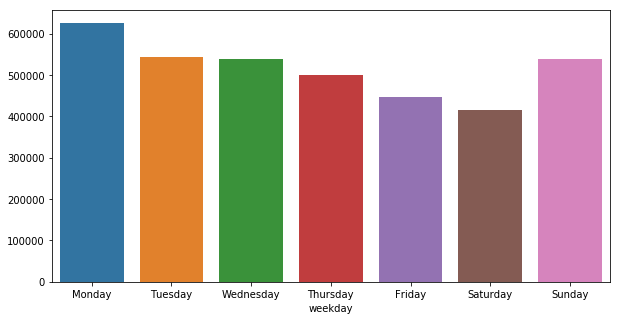

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

sns.barplot(x = clac3_week.index, y=clac3_week.values, order = order)

**요일별 데이터 나누기**

In [14]:
for x in clac3_week.index:
    d = x[:3].lower()
    globals()[d] = clac3_dup[clac3_dup['weekday'] == x].drop(['weekday'], axis = 1).reset_index(drop = 'level_0')

In [15]:
mon.head(3), tue.head(3), wed.head(3), thu.head(3), fri.head(3), sat.head(3), sun.head(3),

(   CLNT_ID    SESS_DT   CLAC3_NM
 0       32 2018-09-17   여성양말선물세트
 1       59 2018-09-24  식기건조대/수저통
 2       63 2018-06-11        미스트,    CLNT_ID    SESS_DT CLAC3_NM
 0        8 2018-06-05   여성클러치백
 1       14 2018-09-11     여성시계
 2       25 2018-07-03    페이셜팩류,    CLNT_ID    SESS_DT CLAC3_NM
 0        8 2018-06-06   여성클러치백
 1       25 2018-04-25     일반두유
 2       33 2018-04-11    스킨/토너,    CLNT_ID    SESS_DT  CLAC3_NM
 0       25 2018-06-21      일반두유
 1       51 2018-05-03      음료용컵
 2       58 2018-07-19  남성스포츠티셔츠,    CLNT_ID    SESS_DT CLAC3_NM
 0       25 2018-05-18     일반두유
 1       68 2018-07-13     제모용품
 2       68 2018-08-10   메이크업세트,    CLNT_ID    SESS_DT  CLAC3_NM
 0       33 2018-04-07    페이셜클렌저
 1       63 2018-09-08   남성캐주얼재킷
 2       68 2018-07-21  립스틱/립라이너,    CLNT_ID    SESS_DT   CLAC3_NM
 0       56 2018-08-26    핸드로션/크림
 1       59 2018-09-23  식기건조대/수저통
 2       59 2018-09-23  국자/뒤지개/주걱)

**월요일 분석**

In [55]:
dataset = mon.groupby(['CLNT_ID','SESS_DT','CLAC3_NM']).size().unstack(fill_value=0)

문제점

- astype(bool) 붙으면 커널이 죽음

해결법

- 빼고 한다.

In [56]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#지지도
frequent_itemsets = apriori(dataset, min_support=0.003, use_colnames=True) #----> min_support: 최소 지지도
frequent_itemsets = frequent_itemsets.sort_values('support', ascending = False)
frequent_itemsets.reset_index(drop='index', inplace = True)
#신뢰도
frequent_itemsets = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.001) #-----> min_threshold: 최소 신뢰도
frequent_itemsets = frequent_itemsets.sort_values('support', ascending = False)
frequent_itemsets.reset_index(drop='index', inplace = True)
frequent_itemsets

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(남성티셔츠),(남성캐주얼바지),0.060969,0.027205,0.007569,0.124144,4.563320,0.005910,1.110680
1,(남성캐주얼바지),(남성티셔츠),0.027205,0.060969,0.007569,0.278221,4.563320,0.005910,1.300995
2,(여성남방셔츠),(여성티셔츠/탑),0.032018,0.032465,0.004563,0.142524,4.390049,0.003524,1.128352
3,(여성티셔츠/탑),(여성남방셔츠),0.032465,0.032018,0.004563,0.140559,4.390049,0.003524,1.126293
4,(여성바지),(여성티셔츠/탑),0.023229,0.032465,0.003950,0.170046,5.237784,0.003196,1.165769
5,(여성티셔츠/탑),(여성바지),0.032465,0.023229,0.003950,0.121669,5.237784,0.003196,1.112076
6,(여성남방셔츠),(여성바지),0.032018,0.023229,0.003836,0.119802,5.157399,0.003092,1.109717
7,(여성바지),(여성남방셔츠),0.023229,0.032018,0.003836,0.165127,5.157399,0.003092,1.159437
8,(여성남방셔츠),(여성원피스),0.032018,0.040701,0.003789,0.118345,2.907668,0.002486,1.088066
9,(여성원피스),(여성남방셔츠),0.040701,0.032018,0.003789,0.093097,2.907668,0.002486,1.067349


- 결과에 의류 카테고리만 나옴.
- 남성티셔츠와 남성캐주얼바지를 같이 구매한 경우는 전체의 0.7%이다.
- 남성티셔츠를 샀을 때, 남성캐주얼바지를 구매할 확률은 12.4%이다.
- 남성티셔츠와 남성캐주얼바지의 향상도가 약 4.5 연관성이 어느 정도 있음.

문제점

- 연산이 오래걸림/지지도가 너무 낮음(종류가 많기 때문)

해결법

- 군집화 혹은 RFM 모델로 그룹을 나누어 vip그룹을 분석한다.